In [ ]:
# System Installation / Preparation (macOS Homebrew)
brew install graphviz

In [ ]:
# Pip Installation / Preparation
pip install pydot
pip install tensorflow
pip install scikit-learn

In [1]:
# Python imports
import tensorflow as tf
import keras
from keras import layers
import pydot
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

2024-03-12 14:17:14.771910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data as pandas dataframe
df = pd.read_csv("./data.csv")

# Print: first records
df.head()

,C1,H1,C2,H2,C3,H3,C4,H4,C5,H5,C6,H6
0,P,R,P,S,R,R,P,S,S,S,S,S
1,R,R,R,R,S,R,R,R,P,R,R,S
2,S,S,S,S,S,R,S,S,P,R,S,S
3,P,S,R,S,P,R,P,S,S,S,S,S
4,R,R,S,R,R,R,R,S,R,S,P,R


In [ ]:
# DO DATASET STUFF
# Nachdenken über sinnvolle Eingabe-Ausgabe Paare.
# One hot encoding (oder welche auch immer den 2D vektor der dimension 3 gibt)
# C und H seperat betrachten

# (R, P), (S, S), (<mask>, _), (_, _), (_, _), (_, _) --> ?

# ([R, P, S], 1), ([R, P, S], 0), ([R, P, S], 1) --> [R, P, S] 
# ([0, 1, 0], 1), ([0, 0, 1], 0), ([1, 0, 0], 1) --> [0, 0, 1] 

# C - Computer (zufallsgenneriter wert)
# H - Human (zugehöriges menschl. Spiel)

In [ ]:


#with open('data.csv', 'r') as file:
#    csv_data = file.read().rstrip()
#print(csv_data)
    
## transform into matrix ##
#csv_lines = csv_data.splitlines()
#print(csv_lines)
#csv_arr = []
#for i in csv_lines:
#    reader = csv.reader([i])
#    fields = next(reader)
#    csv_arr.append(fields)
#print(csv_arr)

#csv_mat = np.mat(csv_arr)
#print(csv_mat)


In [3]:
# Get dimension of input data frame
num_rows, num_cols = df.shape
print(num_rows, num_cols)

40 12


In [4]:
# Select the record sets from the input data frame
record_sets = []
set_start_index = 0
set_end_index = 2
for index in range(int(num_cols/2)):
    record_sets.append(df.iloc[0:,set_start_index:set_end_index])
    set_start_index = set_start_index + 2
    set_end_index = set_end_index + 2

# Print: first record set
record_sets[0]

,C1,H1
0,P,R
1,R,R
2,S,S
3,P,S
4,R,R
5,P,S
6,R,S
7,R,S
8,P,S
9,S,S


In [5]:
# Check the winner for each record in all record sets
wins = []
for index in range(len(record_sets)):
    winner_arr = []
    record_set = record_sets[index]
    for row in range(num_rows):
        #print(record_set.iloc[row,0], record_set.iloc[row,1])
        if record_set.iloc[row,1] == record_set.iloc[row,0]:
            winner_arr.append(0)                                # tie
        elif record_set.iloc[row,1] == 'R':                     # player = record_set[row,1]
            if record_set.iloc[row,0] == 'P':                   # computer = record_set[row,0]
                winner_arr.append(-1)                           # player lose
            if record_set.iloc[row,0] == 'S':
                winner_arr.append(1)                            # player win
        elif record_set.iloc[row,1] == 'S':
            if record_set.iloc[row,0] == 'R':
                winner_arr.append(-1)
            if record_set.iloc[row,0] == 'P':
                winner_arr.append(1)
        elif record_set.iloc[row,1] == 'P':
            if record_set.iloc[row,0] == 'S':
                winner_arr.append(-1)
            if record_set.iloc[row,0] == 'R':
                winner_arr.append(1)
    wins.append(winner_arr)

# Print: wins array of arrays ( = 2D array)
print(wins)

[[-1, 0, 0, 1, 0, 1, -1, -1, 1, 0, -1, 0, -1, 0, 1, -1, -1, 0, -1, -1, -1, 1, 1, -1, -1, 0, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1], [1, 0, 0, -1, 1, 0, 1, 0, -1, -1, 0, -1, 0, 1, 1, 1, 1, -1, 1, 1, -1, 0, 1, -1, 0, 1, 0, -1, 1, -1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 1, 1, -1, 0, -1, 0, -1, 1, 1, 1, 1, -1, 1, 1, 0, 1, 0, 1, 1, -1, 1, 1, 1, 1, -1, 0, 0, 1, 0, 1, 1, 0, 0, -1, 0, 0, -1, 0, 0], [1, 0, 0, 1, -1, 1, -1, 1, -1, 1, 1, 1, 0, 0, 1, 1, 1, -1, 1, -1, 0, -1, 0, -1, 1, 0, -1, 1, 1, 0, 1, -1, 1, 0, -1, 1, 0, 1, 0, 0], [0, -1, -1, 0, -1, 1, -1, 0, 0, 1, 0, -1, -1, 0, -1, 1, 0, 1, 1, 0, -1, 1, 0, 1, 0, -1, 1, 0, 0, -1, -1, 1, 1, 0, 1, 0, 0, 1, 0, 1], [0, -1, 0, 0, -1, -1, 1, -1, 1, 0, 1, 1, 1, 0, -1, 1, 0, 1, 0, 0, 0, 1, 1, 0, -1, 0, 1, 1, -1, -1, -1, 0, 1, 0, 0, -1, -1, 0, -1, -1]]


In [6]:
# Convert wins array to Pandas data frame
win_dfs = []
for index in range(len(wins)):
    header = 'W' + str(index + 1)
    win_df = pd.DataFrame(wins[index], columns=[header])
    win_dfs.append(win_df)

# Print: first data frame
win_dfs[0]

,W1
0,-1
1,0
2,0
3,1
4,0
5,1
6,-1
7,-1
8,1
9,0


In [7]:
# Create OneHotEncoder categories of the input data frame
enc = OneHotEncoder()
enc.fit(df.to_numpy().flatten().reshape(-1, 1))

# Print: array of OneHotEncoder categories
enc.categories_

[array(['P', 'R', 'S'], dtype=object)]

In [8]:
# Sample one hot encoding by the created OneHotEncoder
sample = enc.transform(np.array('R').reshape(-1, 1))
sample.toarray()

array([[0., 1., 0.]])

In [9]:
# One hot encoding of the input data frame
one_hot_df = df.applymap(lambda x: enc.transform(np.array(x).reshape(-1, 1)).toarray()[0])

# Print: one hot encoded input data frame
one_hot_df

/var/folders/2s/5cscz1vx1v5g8zylrntppy440000gn/T/ipykernel_12813/1582091877.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  one_hot_df = df.applymap(lambda x: enc.transform(np.array(x).reshape(-1, 1)).toarray()[0])


,C1,H1,C2,H2,C3,H3,C4,H4,C5,H5,C6,H6
0,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
3,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
4,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
5,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
6,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"
7,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
8,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]"
9,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"


In [10]:
# Select the one hot encoded record sets from the input data frame
one_hot_record_sets = []
one_hot_set_start_index = 0
one_hot_set_end_index = 2
for index in range(int(num_cols/2)):
    one_hot_record_sets.append(one_hot_df.iloc[0:,one_hot_set_start_index:one_hot_set_end_index])
    one_hot_set_start_index = one_hot_set_start_index + 2
    one_hot_set_end_index = one_hot_set_end_index + 2

# Print: first one hot encoded record set
one_hot_record_sets[0]

,C1,H1
0,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
3,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"
4,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
5,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"
6,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
7,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"
8,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"
9,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"


In [11]:
# Combine/Concat one hot-encoded record sets with the wins data frames
combined_record_sets = []
for index in range(len(one_hot_record_sets)):
    #one_hot_record_set = one_hot_df[['C1','H1']]
    stacked = pd.concat([one_hot_record_sets[index], win_dfs[index]], axis=1)
    combined_record_sets.append(stacked)

# Print: first combined record set
combined_record_sets[0]

# Aus H1 und W1 [[1, 0, 0], -1]

,C1,H1,W1
0,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0
3,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
4,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
5,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
6,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
7,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
8,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
9,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0


In [12]:
# Set the number of rows for the training and validation data
training_rows = round(num_rows * 0.7)
print(training_rows)

28


In [13]:
# Split combined record sets into training and validation data
training_record_sets = []
validation_record_sets = []
for index in range(len(combined_record_sets)):
    record_set = combined_record_sets[index]
    # split
    training_set = record_set.iloc[:training_rows]
    validation_set = record_set.iloc[training_rows:]
    # append
    training_record_sets.append(training_set)     
    validation_record_sets.append(validation_set)       

# Print: first training record set
training_record_sets[0]

,C1,H1,W1
0,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0
3,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
4,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
5,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
6,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
7,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
8,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
9,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0


In [14]:
# Rename headers for merging
renamed_training_sets = []
renamed_validation_sets = []
# Training data sets
for index in range(len(training_record_sets)):
    record_set = training_record_sets[index]
    header_com = 'C' + str(index + 1)
    header_human = 'H' + str(index + 1)
    header_win = 'W' + str(index + 1)
    renamed_training_sets.append(record_set.rename(columns={header_com: "C", header_human: "H", header_win: "W"}))
# Validation data sets
for index in range(len(validation_record_sets)):
    record_set = validation_record_sets[index]
    header_com = 'C' + str(index + 1)
    header_human = 'H' + str(index + 1)
    header_win = 'W' + str(index + 1)
    renamed_validation_sets.append(record_set.rename(columns={header_com: "C", header_human: "H", header_win: "W"}))

# Print: first renamed validation sets
renamed_validation_sets[0]

,C,H,W
28,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
29,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]",1
30,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
31,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
32,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
33,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
34,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
35,"[0.0, 0.0, 1.0]","[1.0, 0.0, 0.0]",-1
36,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
37,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1


In [15]:

# Merge training and valitation record sets into one training and one validation data frame
# Create training and validation data drame
x_training_df = pd.DataFrame(columns=['C', 'H', 'W'])
y_training_df = pd.DataFrame(columns=['C', 'H', 'W'])

x_validation_df = pd.DataFrame(columns=['C', 'H', 'W'])
y_validation_df = pd.DataFrame(columns=['C', 'H', 'W'])
# Training
for index in range(len(renamed_training_sets)):
    training_set = renamed_training_sets[index]
    validation_set = renamed_validation_sets[index]
    # x
    x_training_df = pd.concat([x_training_df, training_set], axis=0)
    # y
    y_training_df = pd.concat([y_training_df, training_set.iloc[1:,0:]], axis=0)
    y_training_df = pd.concat([y_training_df, validation_set.iloc[0:1,0:]], axis=0)
#Valitation
for index in range(len(renamed_validation_sets)):
    validation_set = renamed_validation_sets[index]
    # x
    x_validation_df = pd.concat([x_validation_df, validation_set.iloc[:-1,0:]], axis=0)
    # y
    y_validation_df = pd.concat([y_validation_df, validation_set.iloc[1:,0:]], axis=0)
    #empty_df = pd.DataFrame([[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0],[0.0, 0.0, 0.0]]],columns=['C', 'H', 'W'])
    #y_validation_df = pd.concat([y_validation_df, empty_df], axis=0)

# Print: training data frame
x_training_df

,C,H,W
0,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]",-1
1,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
2,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0
3,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]",1
4,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
...,...,...,...
23,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0
24,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]",-1
25,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0
26,"[0.0, 0.0, 1.0]","[0.0, 1.0, 0.0]",1


In [16]:
# Define maschiene lerning model
# Input as _, R, P, S

one_hot_input = keras.Input(shape=(3,), name='one_hot_input')
winner_input = keras.Input(shape=(1,), name="winner_input")

inputs = keras.layers.Concatenate()([one_hot_input, winner_input])
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(3, activation="softmax", name="predictions")(x)
# Output 0, 1, 2

In [17]:
## Get model Step 2 ##
model = keras.Model(inputs=[one_hot_input, winner_input], outputs=outputs)

In [18]:
model.compile(loss='categorical_crossentropy',
          optimizer=keras.optimizers.Adam(),
          metrics=['accuracy'])

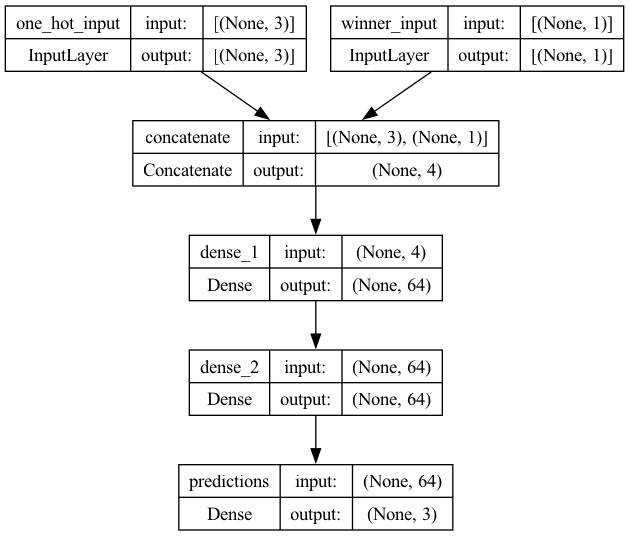

In [19]:
keras.utils.plot_model(model, "RPS.png", show_shapes=True)

In [20]:
x_train = x_training_df.iloc[0:,1:]
x_train_one_hot = tf.constant(np.array(x_train['H'].tolist()))
x_train_winner = tf.constant(x_train['W'].astype('int32'))

In [21]:
y_train = y_training_df.iloc[0:,1:2]
y_train = tf.constant(np.array(y_train['H'].tolist()))
y_train

<tf.Tensor: shape=(168, 3), dtype=float64, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
     

In [22]:
x_val = x_validation_df.iloc[0:,1:]
x_val_one_hot = tf.constant(np.array(x_val['H'].tolist()))
x_val_winner = tf.constant(x_val['W'].astype('int32'))

In [23]:
y_val = y_validation_df.iloc[0:,1:2]
y_val = tf.constant(np.array(y_val['H'].tolist()))
y_val

<tf.Tensor: shape=(66, 3), dtype=float64, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
      

In [24]:
print("Fit model on training data")
history = model.fit(
    {'one_hot_input': x_train_one_hot, 'winner_input': x_train_winner}, # letztes H, letzter Siegwert, H(n) + W(n)
    y_train, # neues H, H(n+1)
    batch_size=32,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=({'one_hot_input': x_val_one_hot, 'winner_input': x_val_winner}, y_val),
)

Fit model on training data
Epoch 1/10
6/6 [==============================] - 1s 37ms/step - loss: 1.1109 - accuracy: 0.3214 - val_loss: 1.0729 - val_accuracy: 0.3636
Epoch 2/10
6/6 [==============================] - 0s 6ms/step - loss: 1.0476 - accuracy: 0.4643 - val_loss: 1.0200 - val_accuracy: 0.5455
Epoch 3/10
6/6 [==============================] - 0s 6ms/step - loss: 1.0102 - accuracy: 0.4286 - val_loss: 0.9846 - val_accuracy: 0.3030
Epoch 4/10
6/6 [==============================] - 0s 6ms/step - loss: 0.9833 - accuracy: 0.4524 - val_loss: 0.9547 - val_accuracy: 0.5455
Epoch 5/10
6/6 [==============================] - 0s 6ms/step - loss: 0.9657 - accuracy: 0.4821 - val_loss: 0.9369 - val_accuracy: 0.5455
Epoch 6/10
6/6 [==============================] - 0s 6ms/step - loss: 0.9525 - accuracy: 0.4762 - val_loss: 0.9299 - val_accuracy: 0.3788
Epoch 7/10
6/6 [==============================] - 0s 6ms/step - loss: 0.9470 - accuracy: 0.4524 - val_loss: 0.9255 - val_accuracy: 0.3788
Epoch 

In [25]:
history.history

{'loss': [1.1109403371810913,
  1.047597885131836,
  1.010241150856018,
  0.9832544922828674,
  0.9657238721847534,
  0.9524663090705872,
  0.9469577074050903,
  0.9441729187965393,
  0.9415240287780762,
  0.9413126707077026],
 'accuracy': [0.3214285671710968,
  0.4642857015132904,
  0.4285714328289032,
  0.4523809552192688,
  0.4821428656578064,
  0.4761904776096344,
  0.4523809552192688,
  0.4702380895614624,
  0.5,
  0.494047611951828],
 'val_loss': [1.0729166269302368,
  1.0199694633483887,
  0.9845801591873169,
  0.9547456502914429,
  0.9368889331817627,
  0.9299317598342896,
  0.9255165457725525,
  0.9174100756645203,
  0.9170001149177551,
  0.921062707901001],
 'val_accuracy': [0.3636363744735718,
  0.5454545617103577,
  0.3030303120613098,
  0.5454545617103577,
  0.5454545617103577,
  0.3787878751754761,
  0.3787878751754761,
  0.6212121248245239,
  0.6212121248245239,
  0.43939393758773804]}

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test) # Adjust for your dataset stuff
print("predictions shape:", predictions.shape)

Evaluate on test data


NameError: name 'x_test' is not defined

In [30]:
model.save("./rps_model.keras", overwrite=True)

In [32]:
model = keras.saving.load_model("./rps_model.keras")